### Data Import

Downloaded the data file News_SocialMedia.csv. This file contains titles and headlines from 93,239 news articles shared on Facebook, LinkedIn, and GooglePlus. We will use just the Title, Headline, and Topic columns of this data set in this assignment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os
import time

%matplotlib inline



In [2]:
news_socialmedia_data = pd.read_csv('News_SocialMedia.csv')
print(news_socialmedia_data.shape)
news_socialmedia_data.head(2)

(93239, 11)


,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1


### Data Preprocessing

In [3]:
# Checked for null values in the data
news_socialmedia_data.isna().sum()

IDLink                 0
Title                  0
Headline              15
Source               279
Topic                  0
PublishDate            0
SentimentTitle         0
SentimentHeadline      0
Facebook               0
GooglePlus             0
LinkedIn               0
dtype: int64

In [4]:
# Dropped the null values
news_socialmedia_data = news_socialmedia_data[news_socialmedia_data['Headline'].notnull()]
news_socialmedia_data.shape

(93224, 11)

In [5]:
# Cleaned the corpus
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize

word_lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

CleanedHeadline = []
for headline in news_socialmedia_data['Headline']:
    words = regexp_tokenize(headline.lower(), r'[A-Za-z]+')
    words = [word_lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 1]
    CleanedHeadline.append(' '.join(words))

news_socialmedia_data['CleanedHeadline'] = CleanedHeadline

In [6]:
# Checked for any missing values in the cleaned headline
news_socialmedia_data.isna().sum()

IDLink                 0
Title                  0
Headline               0
Source               279
Topic                  0
PublishDate            0
SentimentTitle         0
SentimentHeadline      0
Facebook               0
GooglePlus             0
LinkedIn               0
CleanedHeadline        0
dtype: int64

In [7]:
# Dropped the null values
news_socialmedia_data = news_socialmedia_data[news_socialmedia_data['CleanedHeadline'].notnull()]
news_socialmedia_data.shape

(93224, 12)

In [8]:
news_socialmedia_data.head(2)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,CleanedHeadline
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1,obama lay wreath arlington national cemetery p...
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1,tim haywood investment director business unit ...


In [9]:
# Created a sample from the main dataset for clustering
sample_data = news_socialmedia_data.sample(n = 10000, random_state = 95)

After cleaning of my corpus and sample preparation, I first created the 3 types of input for my clustering models and determined the optimum number of clusters using an elbow curve, and then created a function where based on a simple if condition it creates the respective clustering model, extracts the number of clusters and returns them as the output.

##### Created TF-IDF input

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepared tfidf input for KMeans and similarity matrix for Agglomerative Clustering
list_of_headlines = sample_data['CleanedHeadline'].tolist()
vector = TfidfVectorizer(max_features = 10000, min_df = 0.15, ngram_range = (1, 3))
tfidf = vector.fit_transform(list_of_headlines)
similarity_matrix = (tfidf * tfidf.T).A

##### Created Word Vectors input

In [11]:
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

# Created a tokenized corpus for the word2vec model
tokenized_list = [simple_preprocess(heading) for heading in sample_data['Headline']]
tokenized_corpus = np.array(tokenized_list)
num_features = 100

word2vec_model = Word2Vec(tokenized_corpus, size = num_features, window = 8, min_count = 2, sample = 1e-3, sg = 1, iter = 5, workers = 8)
vocabulary = set(word2vec_model.wv.index2word)

# Used a function to calculate the average word vectors and stored them as an array input
def calculateAverageWordVector(tokens, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in tokens:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

tokenized_features = [calculateAverageWordVector(tokens, word2vec_model, vocabulary, num_features) for tokens in tokenized_corpus]
avg_tokenized_features = np.array(tokenized_features)

<ipython-input-11-a666de996ead>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  tokenized_corpus = np.array(tokenized_list)


##### Created Doc2Vec input

In [12]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Used TaggedDocument to input for Doc2Vec model and calculated the document vectors to use as a input for the models
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_list)]
doc2vec_model = Doc2Vec(documents, size = num_features, window = 8, min_count = 2, workers = 7)
doc2vec_model.train(documents, total_examples = doc2vec_model.corpus_count, epochs = 10)
document_vectors = doc2vec_model.docvecs.vectors_docs

/Users/rasheshkothari/opt/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


##### Elbow curve to determine optimum number of K values

In [13]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import plotly.express as px

# Created a KMeans data using KMeans model with a range of numbers, and then calculated the score for each number
N = range(1, 8)
kmeans_data = [KMeans(n_clusters=i) for i in N]
score = [kmeans_data[i].fit(tfidf).score(tfidf) for i in range(len(kmeans_data))]

# Used a plotly line to plot the elbow curve
fig = px.line(x = N, y = score, title = 'Elbow Curve')
fig.update_layout(xaxis_title = 'Number of Clusters', yaxis_title = 'Score')
fig.show()

### Clustering Models Creation

##### Created clusters using different input types

In [14]:
# As we can see from the above elbow curve, the optimum number of clusters is 4
number_of_clusters = 4

# Used a function that takes corpus, num of clusters and a boolean flag as input
# The function creates KMeans or Agglomerative model based on the boolean input
# The function then calculates the number of clusters and then return them as an array
def createClusters(corpus, num_clusters, isKMeans):
    if isKMeans == True:
        model = KMeans(n_clusters = number_of_clusters)
        model = model.fit(corpus)
    else:
        model = AgglomerativeClustering(n_clusters = number_of_clusters)
        model = model.fit(corpus)
    model_labels = model.labels_
    clusters = model_labels.tolist()
    return clusters

In [15]:
sample_data['KMeansCluster_Tfidf'] = createClusters(tfidf, number_of_clusters, isKMeans = True)
sample_data.head(2)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,CleanedHeadline,KMeansCluster_Tfidf
86778,101986.0,President Obama Believes This Is the Best Soci...,President Obama Believes This Is the Best Soci...,Motley Fool,obama,2016-06-19 11:20:10,-0.055748,-0.197611,569,4,5,president obama belief best social security fi...,1
70657,47655.0,Microsoft to address UN on ‘digital terror’,Microsoft has accepted an invitation from the ...,Manila Bulletin,microsoft,2016-05-06 00:23:00,0.047246,0.076889,1,0,0,microsoft accepted invitation un security coun...,2


##### Plotted clusters for a subset of 3000 records

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS, TSNE

# Used a function that takes the corpus, number of clusters, and two boolean flags as input
# The function calculates distances and two types of manifolds as per an input boolean flag
def plotClusters(corpus, num_clusters, isKMeans, isMDS):
    distance = ''
    if isMDS == True:
        distance = 1 - cosine_similarity(corpus[0:3000])
        manifold = MDS(n_components = 2, dissimilarity = "precomputed", random_state = 95)
    else:
        distance = corpus[0:3000]
        manifold = TSNE(n_components = 2, init = 'random', random_state = 95, perplexity=50)
    pos = manifold.fit_transform(distance)
    xs, ys = pos[:, 0], pos[:, 1]

    # Set up cluster names using a dict
    cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4'}
    cluster_colors = {0: '#6DB31F', 1: '#F83F1D', 2: '#1DB9F8', 3: '#F26FCF'}

    # Created a dataframe which calls the createClusters method for labels, 
    # Grouped them by the labels and plotted the clusters
    cluster_plot_df = pd.DataFrame(dict(x = xs, y = ys, label = createClusters(corpus, num_clusters, isKMeans)[0:3000])) 
    cluster_groups = cluster_plot_df.groupby('label')
    fig, ax = plt.subplots(figsize=(17, 8))

    for name, group in cluster_groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
                label=cluster_names[name], color=cluster_colors[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
    ax.legend(numpoints=1) 
    plt.show()

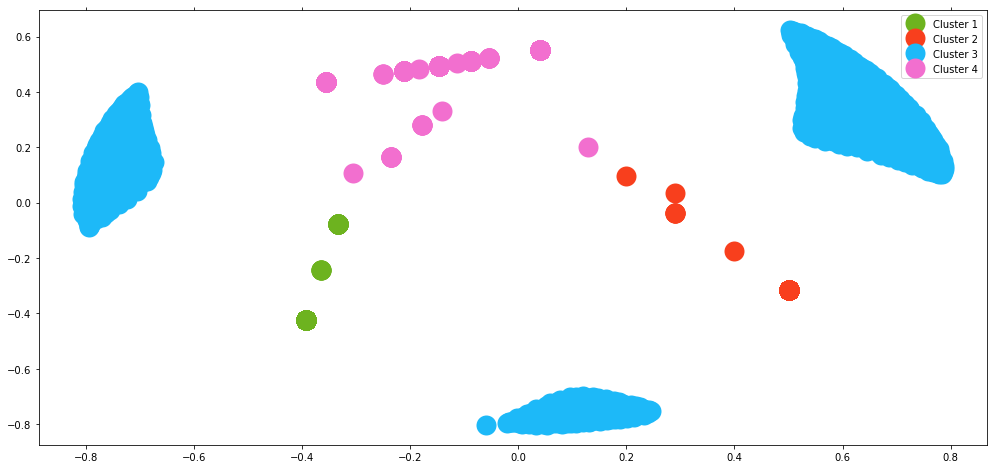

In [17]:
plotClusters(tfidf, number_of_clusters, isKMeans = True, isMDS = True)

In [18]:
sample_data['KMeansCluster_Word2Vec'] = createClusters(avg_tokenized_features, number_of_clusters, isKMeans = True)

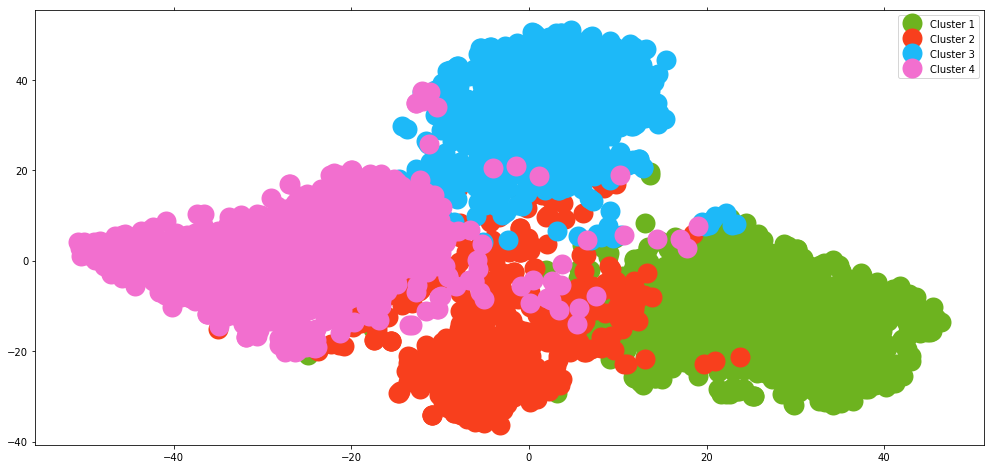

In [19]:
plotClusters(avg_tokenized_features, number_of_clusters, isKMeans = True, isMDS = False)

In [20]:
sample_data['KMeansCluster_Doc2Vec'] = createClusters(document_vectors, number_of_clusters, isKMeans = True)

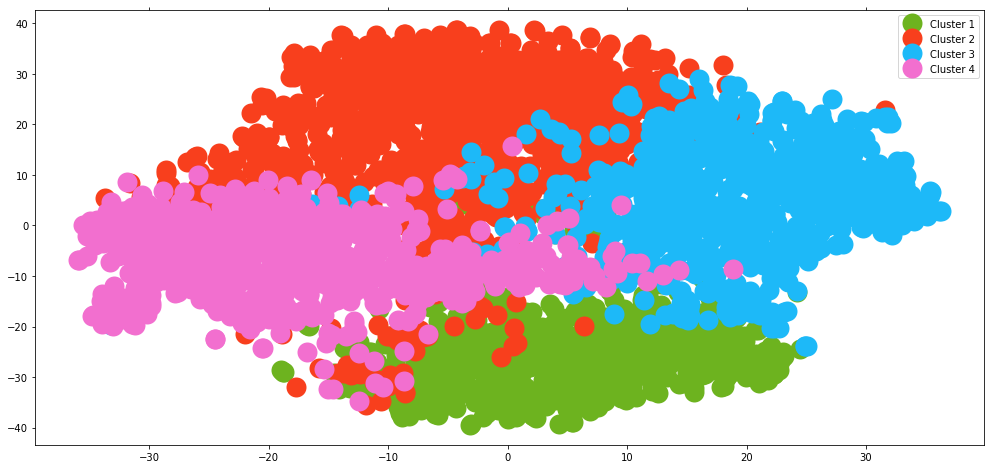

In [21]:
plotClusters(document_vectors, number_of_clusters, isKMeans = True, isMDS = False)

In [22]:
sample_data['AggloCluster_Tfidf'] = createClusters(similarity_matrix, number_of_clusters, isKMeans = False)

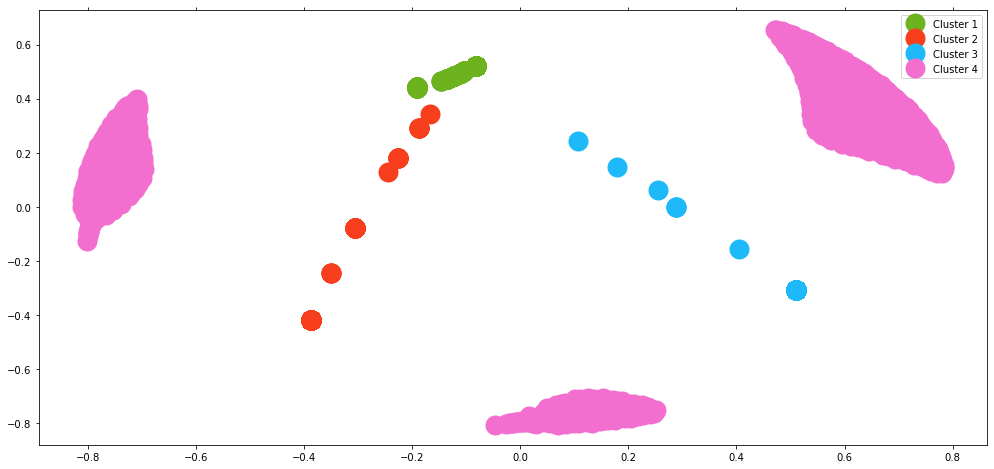

In [23]:
plotClusters(similarity_matrix, number_of_clusters, isKMeans = False, isMDS = True)

In [24]:
sample_data['AggloCluster_Word2Vec'] = createClusters(avg_tokenized_features, number_of_clusters, isKMeans = False)

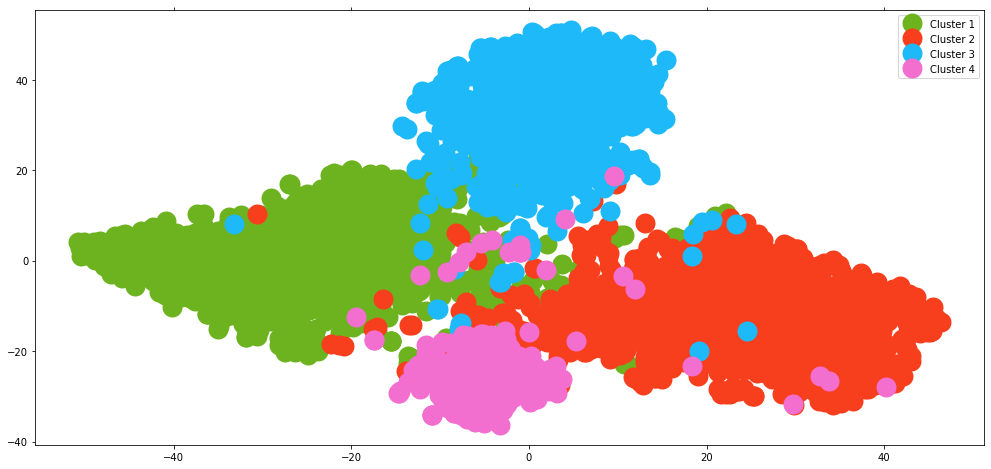

In [25]:
plotClusters(avg_tokenized_features, number_of_clusters, isKMeans = False, isMDS = False)

In [26]:
sample_data['AggloCluster_Doc2Vec'] = createClusters(document_vectors, number_of_clusters, isKMeans = False)

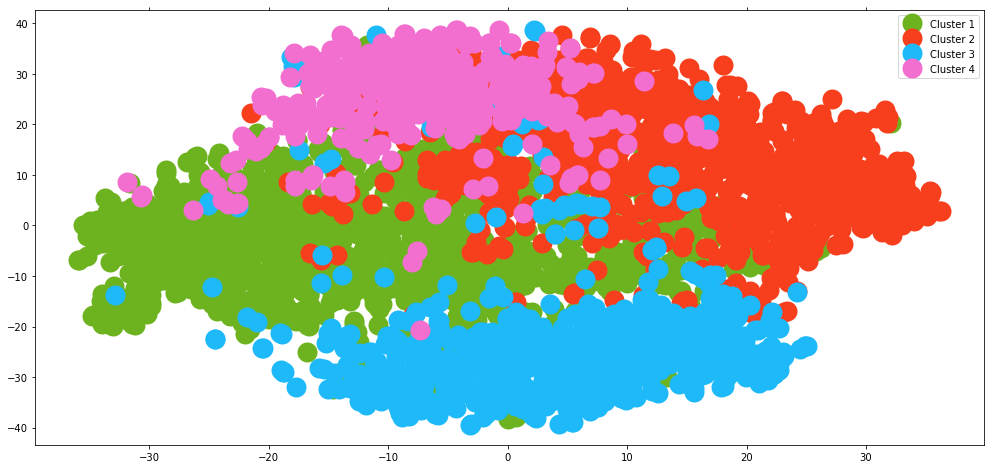

In [27]:
plotClusters(document_vectors, number_of_clusters, isKMeans = False, isMDS = False)

### Comparative Analysis of the 6 Clustering Models

In [28]:
sample_data.iloc[:3, 12:]

,KMeansCluster_Tfidf,KMeansCluster_Word2Vec,KMeansCluster_Doc2Vec,AggloCluster_Tfidf,AggloCluster_Word2Vec,AggloCluster_Doc2Vec
86778,1,0,3,0,0,3
70657,2,3,0,2,1,1
22262,3,1,2,3,0,0


##### Data Visualization using Bar Plots of the different models

In [29]:
# Plotted distribution of topics in clusters
def createComparisonPlots(i, data, column1, column2, input_type):
    plt.subplot(i)
    sb.countplot(data = sample_data, x = column1, hue='Topic')
    plt.title(column1)

    plt.subplot(i+1)
    sb.countplot(data = sample_data, x = column2, hue = 'Topic')
    plt.title(column2)
    plt.suptitle('Distribution of topics using %s'%input_type)

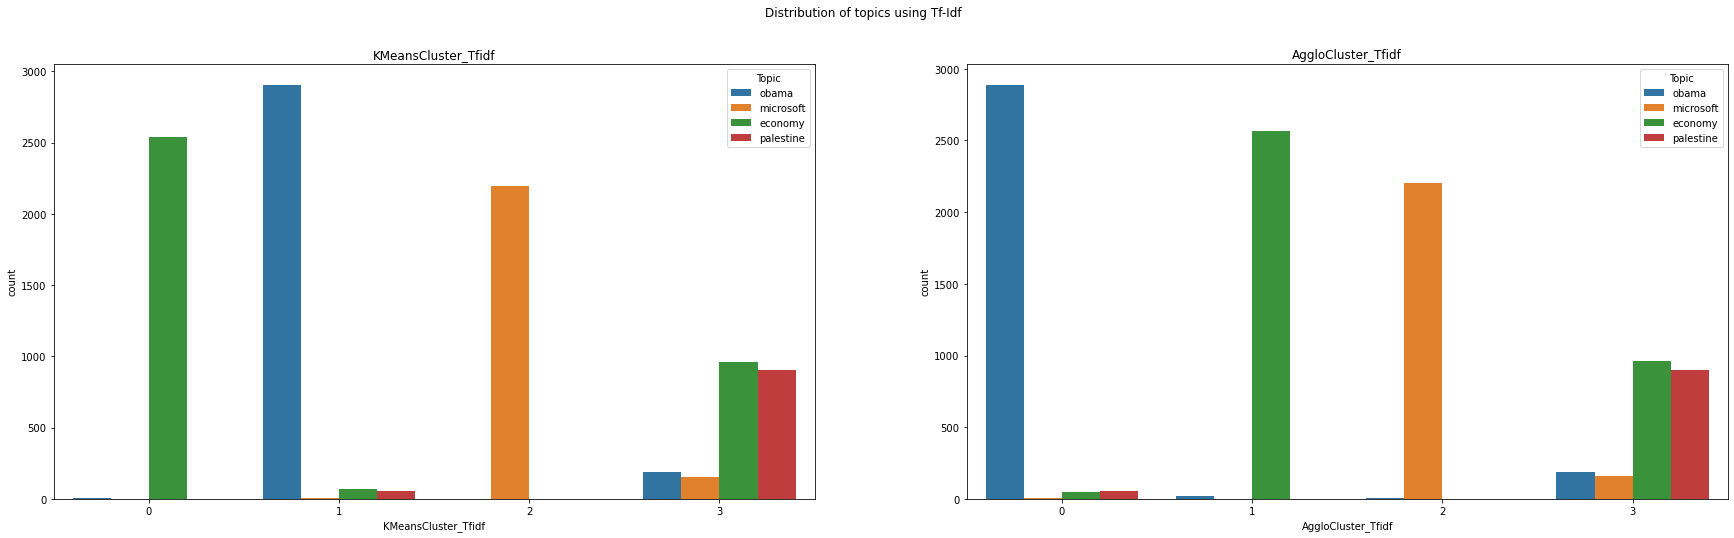

In [30]:
plt.figure(figsize=(30, 8))
createComparisonPlots(121, sample_data, 'KMeansCluster_Tfidf', 'AggloCluster_Tfidf', 'Tf-Idf')
plt.show()

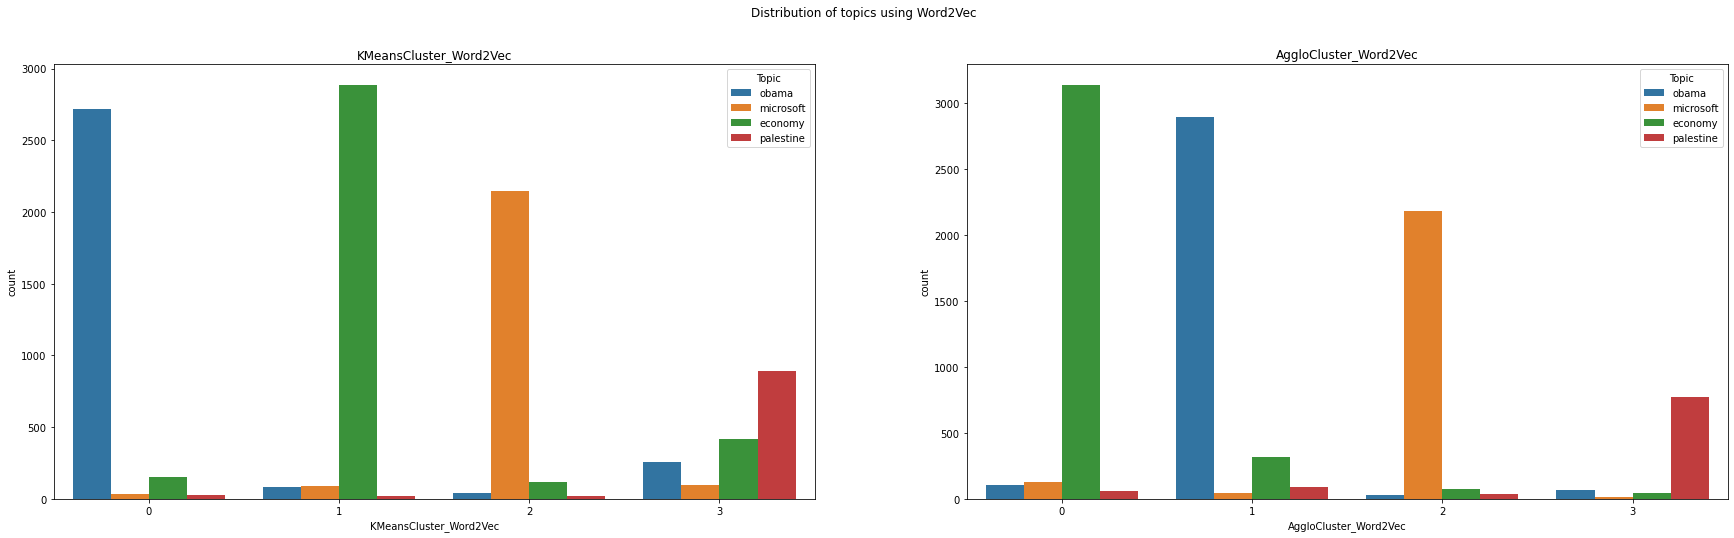

In [31]:
plt.figure(figsize=(30, 8))
createComparisonPlots(121, sample_data, 'KMeansCluster_Word2Vec', 'AggloCluster_Word2Vec', 'Word2Vec')
plt.show()

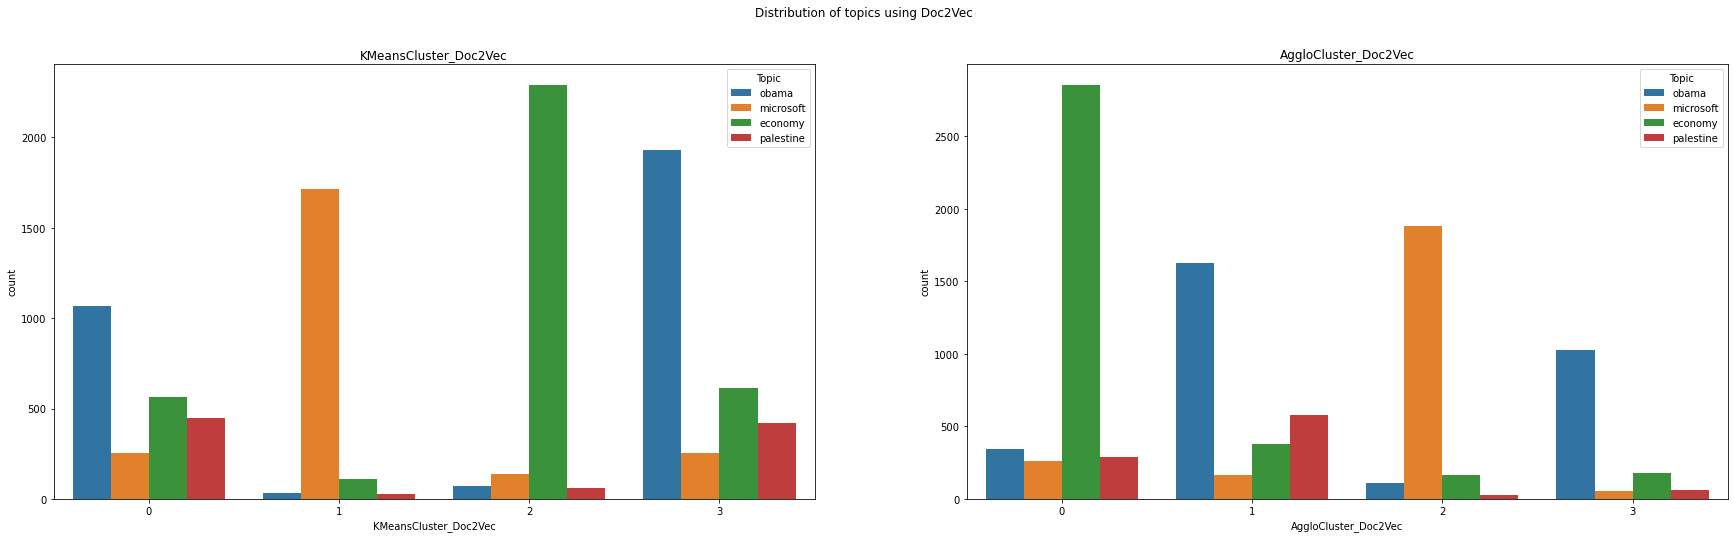

In [32]:
plt.figure(figsize=(30, 8))
createComparisonPlots(121, sample_data, 'KMeansCluster_Doc2Vec', 'AggloCluster_Doc2Vec', 'Doc2Vec')
plt.show()

### Analysis of the Clustering Models

Looking at the visualizations of all the 6 combinations of clustering algorithms and inputs, we could observe the following:
* K-Means vs Agglomerative clustering models with TF-IDF:
    input doesn't seem to isolate topics in different clusters
* Models with Word2Vec: 
       Input clearly provides the best results, especially with the agglomerative model. We can observe that the topics economy, obama, microsoft, and palestine are isolated to a great extent in clusters 0, 1, 2 and 3 respectively. The agglomerative model outperforms K-Means, clearly visible in the above plot as there are mixed topics present in the cluster 0. 
       
* Models with Doc2Vec:
    Input performs better than TF-IDF input models, but when compared to the models created using Word2Vec input, it can be observed that the models couldn't cluster the topics as effectively as the models created using the Word2Vec input.
  


We can therefore say that the Agglomerative model with word2vec input outperforms the models trained using the other input types.

In [34]:
# Exported the final corpus to a csv file
sample_data.drop(['IDLink', 'Source', 'PublishDate', 'SentimentTitle', 'SentimentHeadline', 'Facebook', 'GooglePlus', 'LinkedIn', 'CleanedHeadline'], axis = 1).to_csv('Raj_Ankit_Assignment05_Corpus.csv')